In [11]:
import os
import pydicom
import numpy as np
import pywt
import matplotlib.pyplot as plt

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".dcm"):
            filepath = os.path.join(directory, filename)
            dicom_files.append(pydicom.dcmread(filepath).pixel_array)
    return np.array(dicom_files)

def perform_2d_wavelet_transform1(data):
    coeffs = pywt.dwt2(data, wavelet='haar', mode='periodization')
    coeffs_dict = {'LL': coeffs[0], 'LH': coeffs[1][0], 'HL': coeffs[1][1], 'HH': coeffs[1][2]}
    return coeffs_dict

def perform_3d_wavelet_transform1(data):
    coeffs = pywt.dwtn(data, wavelet='haar', mode='periodization')
    return {
        "LLL": coeffs['aaa'],
        "LLH": coeffs['aad'],
        "LHL": coeffs['ada'],
        "LHH": coeffs['add'],
        "HLL": coeffs['daa'],
        "HLH": coeffs['dad'],
        "HHL": coeffs['dda'],
        "HHH": coeffs['ddd']
    }

def normalize(data):
    data = np.abs(data)
    data = data / np.max(data)
    return data

def display_images(data, title, transform_type):
    if transform_type == '3D':
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2x4 grid
        keys = ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']  
        labels = {'LLL': 'LLL', 'LLH': 'LLH', 'LHL': 'LHL', 'LHH': 'LHH', 
                  'HLL': 'HLL', 'HLH': 'HLH', 'HHL': 'HHL', 'HHH': 'HHH'}
        for i, key in enumerate(keys):
            row, col = divmod(i, 4)
            value = data[key]
            if value.ndim == 3:
                value = value[0]  # Select the first slice if 3D
            value = normalize(value)  # Normalize the data
            axes[row, col].imshow(value, cmap='gray')
            axes[row, col].set_title(f'{title} - {labels[key]}')
            axes[row, col].axis('off')
    elif transform_type == '2D':
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1x4 grid
        keys = ['LL', 'LH', 'HL', 'HH']  # Explicit order
        labels = {'LL': 'LL', 'LH': 'LH', 'HL': 'HL', 'HH': 'HH'}
        for i, key in enumerate(keys):
            value = data[key]
            value = normalize(value)  # Normalize the data
            axes[i].imshow(value, cmap='gray')
            axes[i].set_title(f'{title} - {labels[key]}')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
# Directory containing the DICOM files
dicom_directory = 'Test_Sets/CT/3/DICOM_anon/'

# Read DICOM files
dicom_data = read_dicom_files(dicom_directory)



In [3]:
# # Perform 2D wavelet transform
# wavelet_coeffs_2d = perform_2d_wavelet_transform1(dicom_data[0])  # Use the first slice for 2D transform
# display_images(wavelet_coeffs_2d, 'Wavelet Coefficients', '2D')

In [4]:
# # Perform 3D wavelet transform
# wavelet_coeffs_3d = perform_3d_wavelet_transform1(dicom_data)
# display_images(wavelet_coeffs_3d, 'Wavelet Coefficients', '3D')

MSE for sub-band LLL: 7.589337513001282e-25
MSE for sub-band LLH: 4.549411280440793e-26
MSE for sub-band LHL: 1.6942940235865476e-26
MSE for sub-band LHH: 1.5164899000476683e-26
MSE for sub-band HLL: 4.1249770568252923e-26
MSE for sub-band HLH: 2.819171987493629e-27
MSE for sub-band HHL: 1.849039213476113e-27
MSE for sub-band HHH: 1.3497403833272889e-27


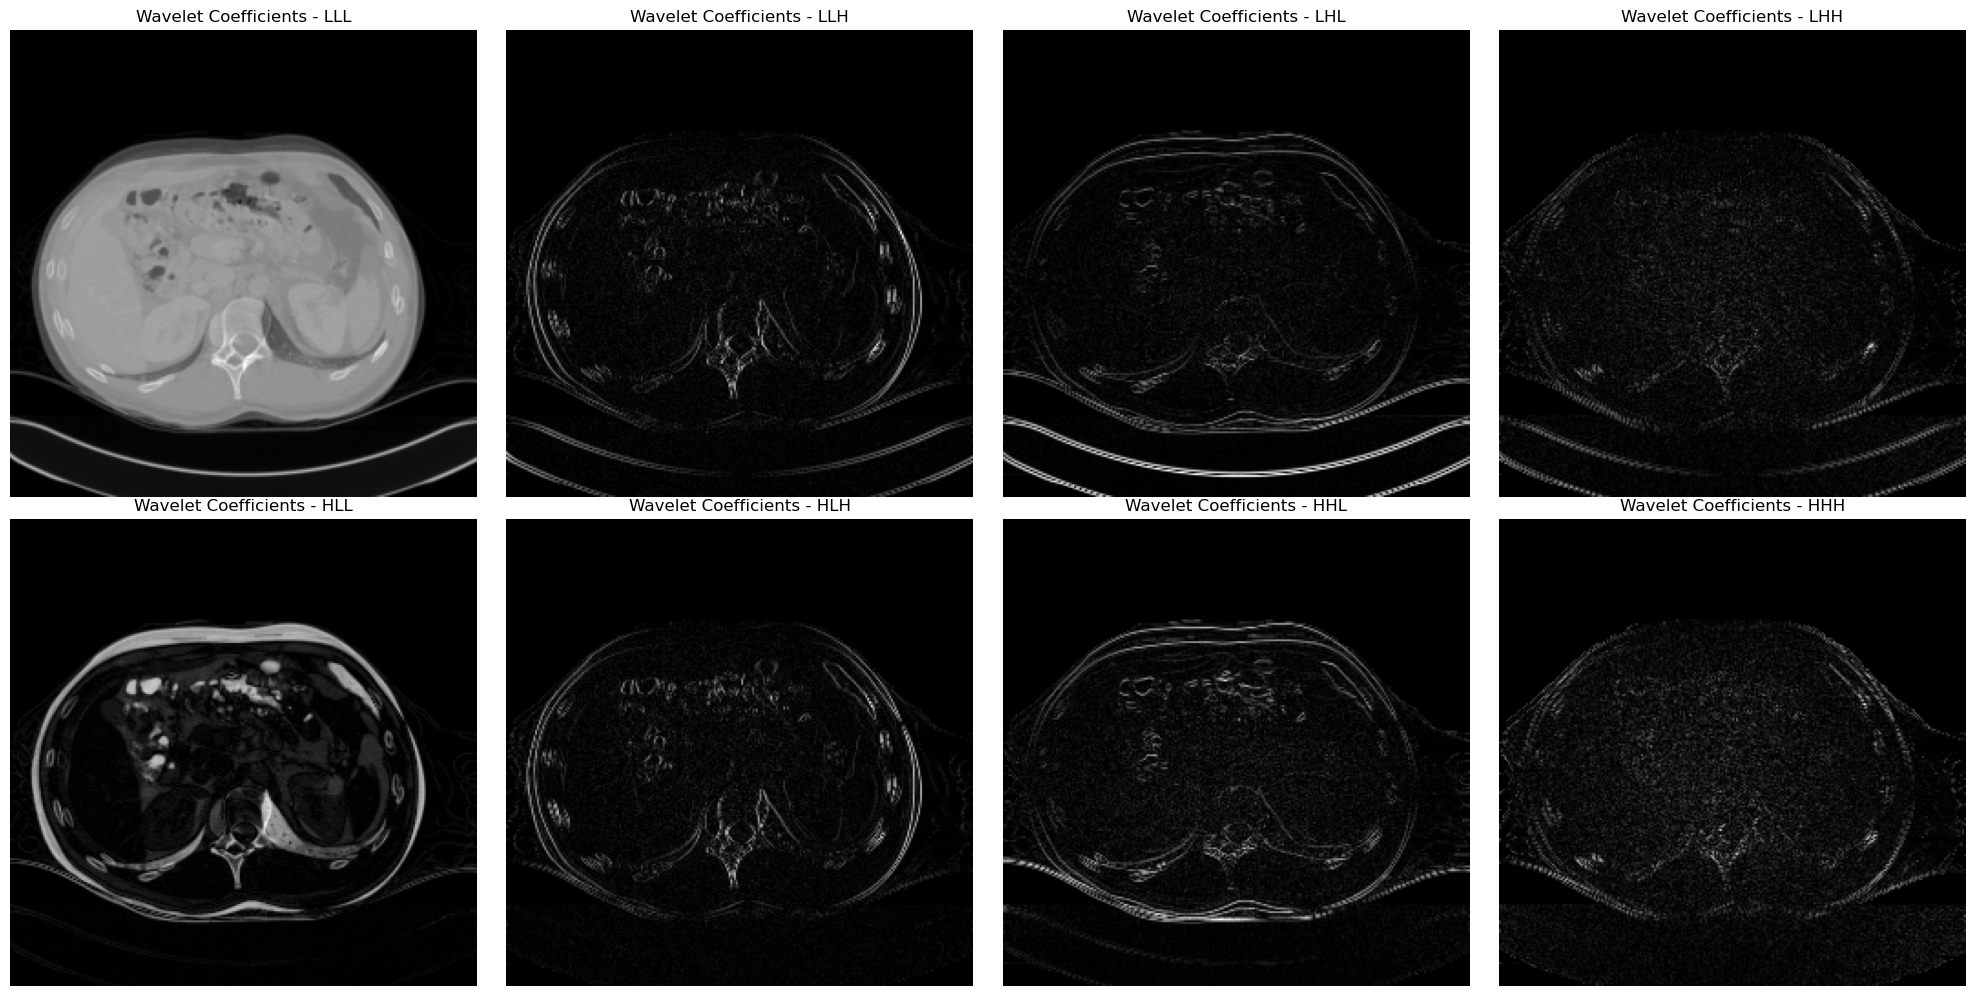

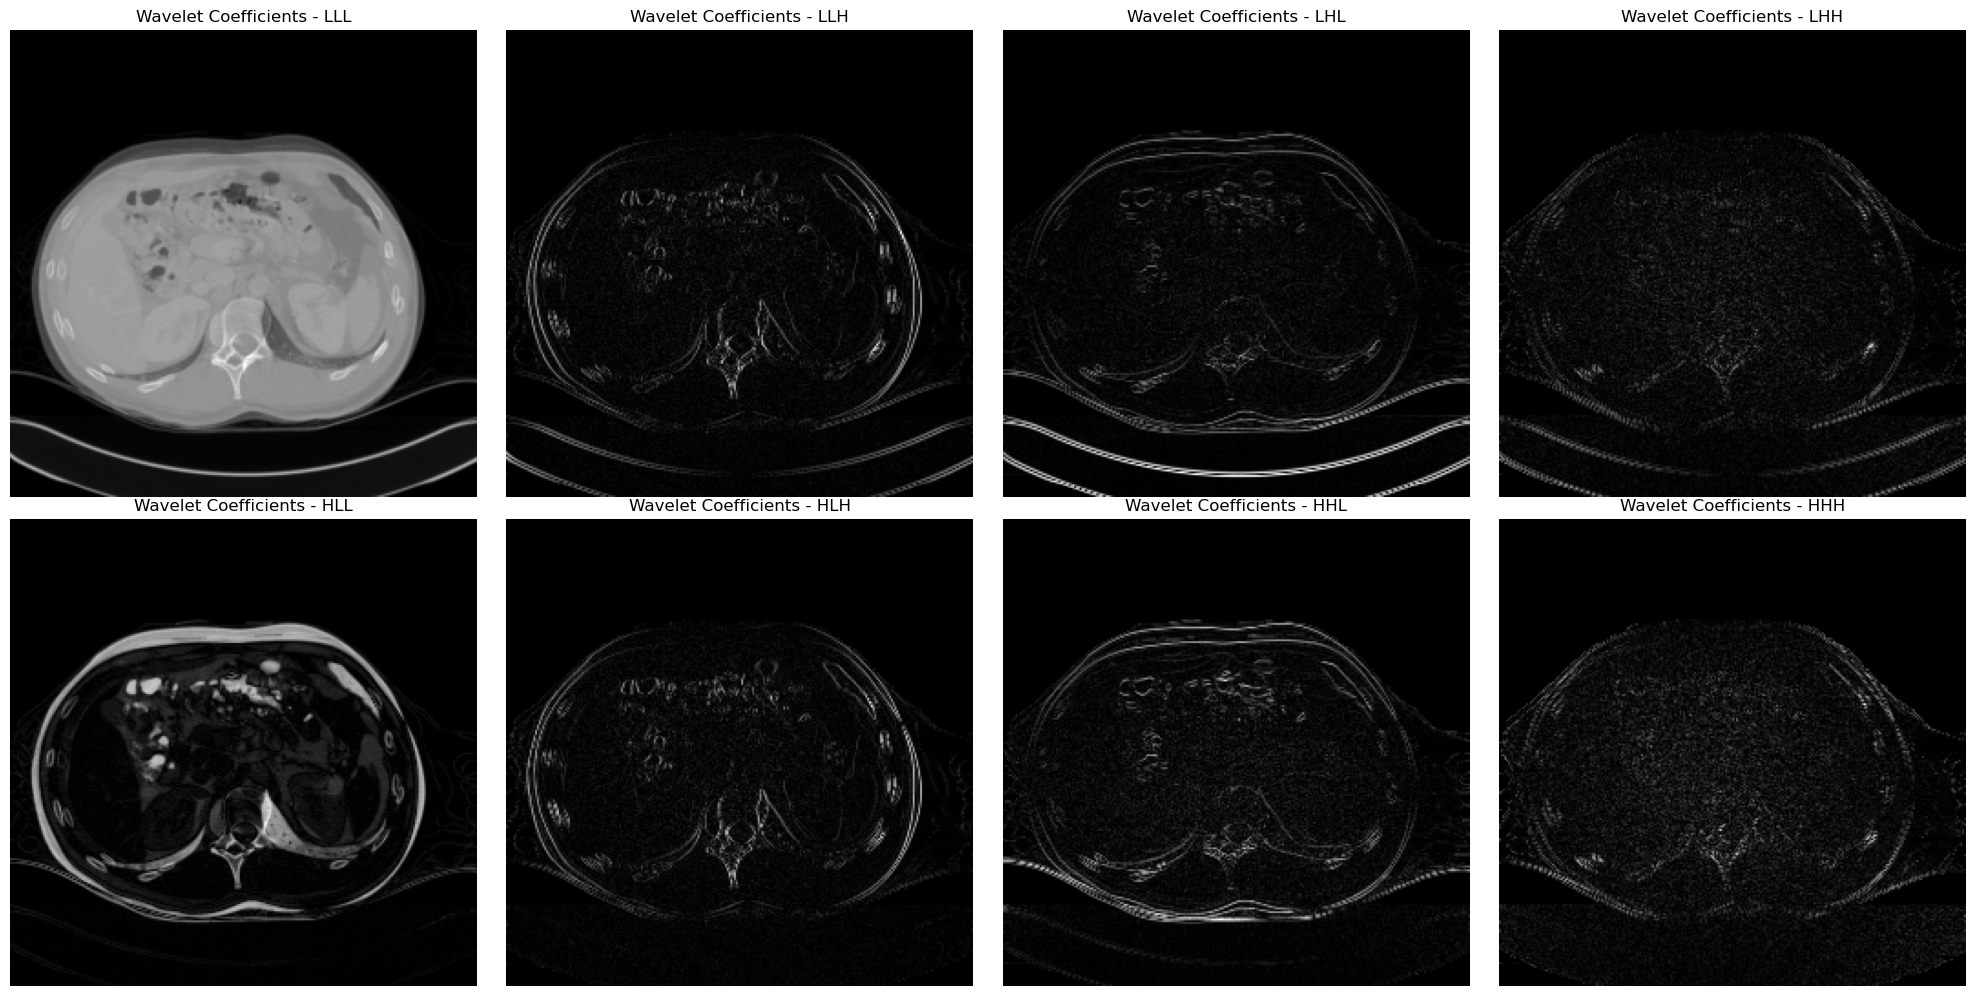

In [14]:
import numpy as np

def convolve(data, filter):
    result = []
    filter_size = len(filter)
    step = 2  # Subsampling factor

    for i in range(0, len(data) - filter_size + 1, step):
        sum = 0.0
        for j in range(filter_size):
            sum += data[i + j] * filter[j]
        result.append(sum)

    return np.array(result)

def perform_2d_wavelet_transform(data):
    low_pass_filter = [1/np.sqrt(2), 1/np.sqrt(2)]  # Normalized Haar filter
    high_pass_filter = [1/np.sqrt(2), -1/np.sqrt(2)]  # Normalized Haar filter

    # Apply 1D convolution and subsampling along rows
    L_rows = np.apply_along_axis(convolve, 1, data, low_pass_filter)
    H_rows = np.apply_along_axis(convolve, 1, data, high_pass_filter)

    # Apply 1D convolution and subsampling along columns
    LL = np.apply_along_axis(convolve, 0, L_rows, low_pass_filter)
    LH = np.apply_along_axis(convolve, 0, L_rows, high_pass_filter)
    HL = np.apply_along_axis(convolve, 0, H_rows, low_pass_filter)
    HH = np.apply_along_axis(convolve, 0, H_rows, high_pass_filter)

    return {"LL": LL, "LH": LH, "HL": HL, "HH": HH}

def perform_3d_wavelet_transform(data):
    low_pass_filter = [1/np.sqrt(2), 1/np.sqrt(2)]  # Normalized Haar filter
    high_pass_filter = [1/np.sqrt(2), -1/np.sqrt(2)]  # Normalized Haar filter

    # Apply 1D convolution and subsampling along the first dimension
    L = np.apply_along_axis(convolve, 0, data, low_pass_filter)
    H = np.apply_along_axis(convolve, 0, data, high_pass_filter)

    # Apply 1D convolution and subsampling along the second dimension
    LL = np.apply_along_axis(convolve, 1, L, low_pass_filter)
    LH = np.apply_along_axis(convolve, 1, L, high_pass_filter)
    HL = np.apply_along_axis(convolve, 1, H, low_pass_filter)
    HH = np.apply_along_axis(convolve, 1, H, high_pass_filter)

    # Apply 1D convolution and subsampling along the third dimension
    LLL = np.apply_along_axis(convolve, 2, LL, low_pass_filter)
    LLH = np.apply_along_axis(convolve, 2, LL, high_pass_filter)
    LHL = np.apply_along_axis(convolve, 2, LH, low_pass_filter)
    LHH = np.apply_along_axis(convolve, 2, LH, high_pass_filter)
    HLL = np.apply_along_axis(convolve, 2, HL, low_pass_filter)
    HLH = np.apply_along_axis(convolve, 2, HL, high_pass_filter)
    HHL = np.apply_along_axis(convolve, 2, HH, low_pass_filter)
    HHH = np.apply_along_axis(convolve, 2, HH, high_pass_filter)

    return {
        "LLL": LLL,
        "LLH": LLH,
        "LHL": LHL,
        "LHH": LHH,
        "HLL": HLL,
        "HLH": HLH,
        "HHL": HHL,
        "HHH": HHH
    }

def normalize(data):
    data = np.abs(data)
    data = data / np.max(data)
    return data

def check_subband_sizes(data, expected_shape):
    for key, subband in data.items():
        if subband.shape != expected_shape:
            print(f"Sub-band {key} has incorrect shape {subband.shape}, expected {expected_shape}")
        else:
            print(f"Sub-band {key} has correct shape {subband.shape}")

def calculate_mse(data1, data2):
    mse_values = {}
    for key in data1.keys():
        mse = np.mean((data1[key] - data2[key]) ** 2)
        mse_values[key] = mse
    return mse_values

def main():
    # Directory containing the DICOM files
    dicom_directory = 'Test_Sets/CT/3/DICOM_anon/'

    # Read DICOM files
    dicom_data = read_dicom_files(dicom_directory)

    # Perform 3D wavelet transform using both methods
    transformed_data1 = perform_3d_wavelet_transform(dicom_data)
    transformed_data2 = perform_3d_wavelet_transform1(dicom_data)

    # Calculate MSE between the results of the two transforms
    mse_values = calculate_mse(transformed_data1, transformed_data2)

    # Print MSE for each sub-band
    for key, mse in mse_values.items():
        print(f"MSE for sub-band {key}: {mse}")

    display_images(transformed_data1, 'Wavelet Coefficients', '3D')
    display_images(transformed_data2, 'Wavelet Coefficients', '3D')

if __name__ == "__main__":
    main()